<a href="https://colab.research.google.com/github/Son-Of-Fry/Clase_NLP/blob/main/Equipo65_chatbot_LLM_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##RAG que es?
RAG (Retrieval-Augmented Generation) es una técnica que combina búsqueda semántica con modelos de lenguaje generativos (LLM) para responder preguntas de forma más precisa y contextualizada.

En lugar de que el modelo responda con lo que “recuerda”, primero se recupera información relevante desde una base de conocimiento (como documentos, PDFs o bases vectoriales), y esa información se inyecta como contexto en el prompt del LLM.


##Etapas de un sistema RAG
1.	Retrieval (recuperación):
Se convierte la pregunta en un vector y se buscan los fragmentos más relevantes usando búsqueda semántica (por ejemplo, con ChromaDB).

2.	Augmented Generation (generación aumentada):
Los fragmentos recuperados se usan como contexto para que el modelo LLM genere una respuesta más precisa, basada en los datos reales.

## ¿Cómo funciona un sistema RAG con búsqueda vectorial?
1.	Embedding (vectorización):
Cada fragmento de texto (por ejemplo, un párrafo del PDF) se convierte en un vector numérico que representa su significado semántico usando modelos como sentence-transformers.

2.	Almacenamiento:
Estos vectores se guardan en una base vectorial como ChromaDB, junto con su texto original.

3.	Consulta del usuario:
Cuando el usuario hace una pregunta, esa también se convierte en vector.

4.	Búsqueda por KNN (k-nearest neighbors):
Se aplica KNN para encontrar los k fragmentos más cercanos al vector de la pregunta. La similitud se calcula típicamente usando distancia coseno.

5.	Generación de respuesta:
Los fragmentos encontrados se concatenan como contexto, y se envían al modelo LLM (como GPT o Gemini), que genera una respuesta basada en esa evidencia.


## Objetivo:

Crear un chatbot que:

1.	Cargue un documento (PDF de la LFT).
2.	Lo divida en fragmentos (chunks).
3.	Cree vectores con sentence-transformers.
4.	Almacene y consulte con Chroma.
5.	Envíe el contexto relevante al modelo Gemini para generar la respuesta.



**Justificación:**

Se seleccionó el modelo OpenAI GPT-3.5 Turbo debido a su buen desempeño en español, bajo costo por token y su capacidad para generar respuestas bien estructuradas a partir de contexto. Originalmente se evaluaron opciones como Gemini y modelos de Hugging Face (flan-t5-base), pero GPT-3.5 ofreció una mejor relación costo-calidad para el despliegue final.

El documento principal usado fue la Ley Federal del Trabajo (PDF actualizado al 2025). Este se dividió en fragmentos y se procesó completamente en español. Se validó su relevancia mediante pruebas reales con preguntas legales comunes. El contenido fue vectorizado de forma completa y almacenado en Chroma.

Esta ley regula las relaciones laborales en el país, estableciendo los derechos y obligaciones tanto de trabajadores como de empleadores. Incluye temas como jornadas laborales, descansos, aguinaldos, licencias, seguridad laboral, despidos y más.

La elección de esta temática responde a varios motivos clave, pero principalmente creemos que las leyes suelen ser complejas, extensas y poco accesibles para la mayoría de la población. Por eso, un chatbot que permita consultar artículos específicos en lenguaje natural ayuda a democratizar el acceso a la información jurídica, haciendo que cualquier persona pueda entender qué dice la ley sin ser abogado. Uno nunca sabe cuando tendrá que defender sus derechos.

Además, la LFT es un documento oficial, de dominio público, fácilmente procesable y con gran riqueza de contenido. Esto la hace perfecta para alimentar un sistema RAG, ya que no hay ambigüedades éticas ni legales en su uso, y su estructura facilita la segmentación en fragmentos semánticos.


El flujo del sistema es el siguiente:
	1.	Se recibe una pregunta del usuario.
	2.	Se convierte a embedding y se busca en Chroma (KNN).
	3.	Se extraen los k fragmentos más cercanos.
	4.	Se arma un prompt que contiene el contexto + pregunta.
	5.	Se envía al LLM (GPT-3.5) y se devuelve la respuesta.

Todas estas operaciones están documentadas en el notebook con funciones separadas y explicadas paso a paso.


##1. Instalación de librerías necesarias

In [ ]:
pip install sentence-transformers PyPDF2 requests chromadb

##2: Cargar y leer el PDF

In [ ]:
from PyPDF2 import PdfReader

pdf_path = "LFT.pdf"  # Asegúrate de tenerlo en el mismo directorio
reader = PdfReader(pdf_path)

text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
print(text[:1000])  # Vista previa del contenido

##3: Dividir el texto en chunks

In [ ]:
chunks = []
partes = text.split(". ")
for i in range(0, len(partes), 4):
    chunk = ". ".join(partes[i:i+4])
    if len(chunk) > 100:
        chunks.append(chunk)

print(f"Total de chunks: {len(chunks)}")

Total de chunks: 2169


##4: Crear base vectorial con Chroma

In [ ]:
import chromadb
from chromadb.utils import embedding_functions

embedding_fn = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="paraphrase-multilingual-MiniLM-L12-v2"
)

chroma_client = chromadb.Client()
collection = chroma_client.get_collection(name="lft_docs", embedding_function=embedding_fn)

# Agregar los chunks con sus IDs
collection.add(documents=chunks, ids=[str(i) for i in range(len(chunks))])

##5: Conectar con Gemini (OpenAI)

In [ ]:
api_key = "sk-proj-"  # pon tu API key aquí
from openai import OpenAI

client = OpenAI(api_key=api_key)

def llamar_a_openai(prompt, modelo="gpt-3.5-turbo"):
    mensaje = [
        {"role": "system", "content": "Eres un asistente experto en la Ley Federal del Trabajo. Responde en español."},
        {"role": "user", "content": prompt}
    ]
    resp = client.chat.completions.create(
        model=modelo,
        messages=mensaje,
        temperature=0.3,
        max_tokens=512
    )
    return resp.choices[0].message.content

##6: Función principal responder_pregunta

In [ ]:
def responder_pregunta(pregunta, k=3):
    resultado = collection.query(query_texts=[pregunta], n_results=k)

    documentos = resultado["documents"][0]
    distancias = resultado["distances"][0]

    print("\n Resultados de búsqueda en Chroma:")
    for i, (doc, dist) in enumerate(zip(documentos, distancias)):
        print(f"\n--- Documento #{i+1} (distancia: {dist:.4f}) ---\n{doc[:300]}...")  # Limita la vista del texto

    contexto = "\n".join(documentos)
    palabras = contexto.split()
    contexto_recortado = " ".join(palabras[:480])

    prompt = f"""Contesta basándote solo en el siguiente texto de la Ley Federal del Trabajo:

{contexto_recortado}

Pregunta: {pregunta}
"""
    print("\n \n")
    print("Respuesta: " + "*"*50)
    return llamar_a_openai(prompt)

##7: Prueba de preguntas reales

In [ ]:
print(responder_pregunta("¿Cuándo se paga el aguinaldo?"))



 Resultados de búsqueda en Chroma:

--- Documento #1 (distancia: 10.3408) ---
- Los trabajadores tendrán derecho a un aguinaldo anual que deberá pagarse antes del 
día veinte de diciembre, equivalente a quince días de salario, por lo menos.  
 
Los que no hayan cumplido el año de servicios, independientemente de que se encuentren laborando 
o no en la fecha de liquidación del...

--- Documento #2 (distancia: 11.5308) ---
- Si no se presentan postores, podrá el actor pedir se le adjudiquen los bienes por el 
precio de su postura, o solicitar la celebración de nuevas almonedas con deducción de un veinte por 
ciento en cada una de ellas. Las almonedas subsecuentes se celebrarán dentro de los treinta días 
siguientes a ...

--- Documento #3 (distancia: 12.2542) ---
 
 
Si al término del plazo señalado en el párrafo anterior no ha concluido el procedimiento o no se ha 
dado cumplimiento a la se ntencia, se pagarán también al trabajador los intereses que se generen sobre 
el importe de quin

In [ ]:
print(responder_pregunta("¿Qué es la jornada laboral nocturna?"))


 Resultados de búsqueda en Chroma:

--- Documento #1 (distancia: 16.4965) ---
 
 
Los trabajadores y el patrón podrán repartir las horas de trabajo, a fin de permitir a los primeros el 
reposo del sábado en la tarde o cualquier modalidad equivalente.  
 
Artículo 60. - Jornada diurna es la comprendida entre las seis y las veinte horas.  
 
 LEY FEDERAL DEL TRABAJO  
 
CÁMARA ...

--- Documento #2 (distancia: 16.7969) ---
CONGRESO DE LA UNIÓN 
Secretaría General  
Secretaría de Servicios Parlamentarios  Última Reforma DOF 21-02-2025  
 
 
22 de 450  
Jornada nocturna es la comprendida entre las veinte y las seis horas.  
 
Jornada mixta es la que comprende períodos de tiempo de las jornadas diurna y nocturna, siempre...

--- Documento #3 (distancia: 17.4767) ---
- Las personas trabajadoras del hogar que residan en el domicilio donde realicen sus 
actividades deberán disfrutar de  un descanso mínimo diario nocturno de nueve horas consecutivas, y de 
un descanso mínimo diario de tres hor

In [ ]:

print(responder_pregunta("¿Cuáles son los derechos de las embarazadas?"))


 Resultados de búsqueda en Chroma:

--- Documento #1 (distancia: 11.9347) ---
 
Artículo derogado DOF 31-12-1974 
 
Artículo 170. - Las madres trabajadoras tendrán los siguientes derechos:  
 
I.  Durante el período del embarazo, no realizarán trabajos que exijan esfuerzos considerables y 
signifiquen un peligro para su salud en relación con la gestación, tales como levan tar...

--- Documento #2 (distancia: 15.4802) ---
 
 
Cuando con motivo de la declaratoria de contingencia sanitaria se ordene la suspensión general de 
labor es, a las mujeres en periodos de gestación o de lactancia les será aplicable lo dispuesto por el 
artículo 429, fracción IV de esta Ley.  
Artículo derogado DOF 31-12-1974. Adicionado  DOF 30...

--- Documento #3 (distancia: 16.1488) ---
 Normas para prevenir los rie sgos de trabajo e instrucciones para prestar los primeros auxilios;  
 
VII.  Labores insalubres y peligrosas que no deben desempeñar los menores y la protección que 
deben tener las trabajadoras e

**Conclusiones**

El sistema mostró ser altamente efectivo para responder preguntas sobre la Ley Federal del Trabajo. Gracias al uso de RAG, se evitó depender solo del conocimiento previo del modelo y se ancló la respuesta en información real y confiable. Además, la integración con Hugging Face permite su acceso público y uso continuo. Como mejora futura, se podría ampliar a otras leyes o integrar más documentos normativos.

Proyecto integrado en https://huggingface.co/spaces/acamposhd/ragchat:

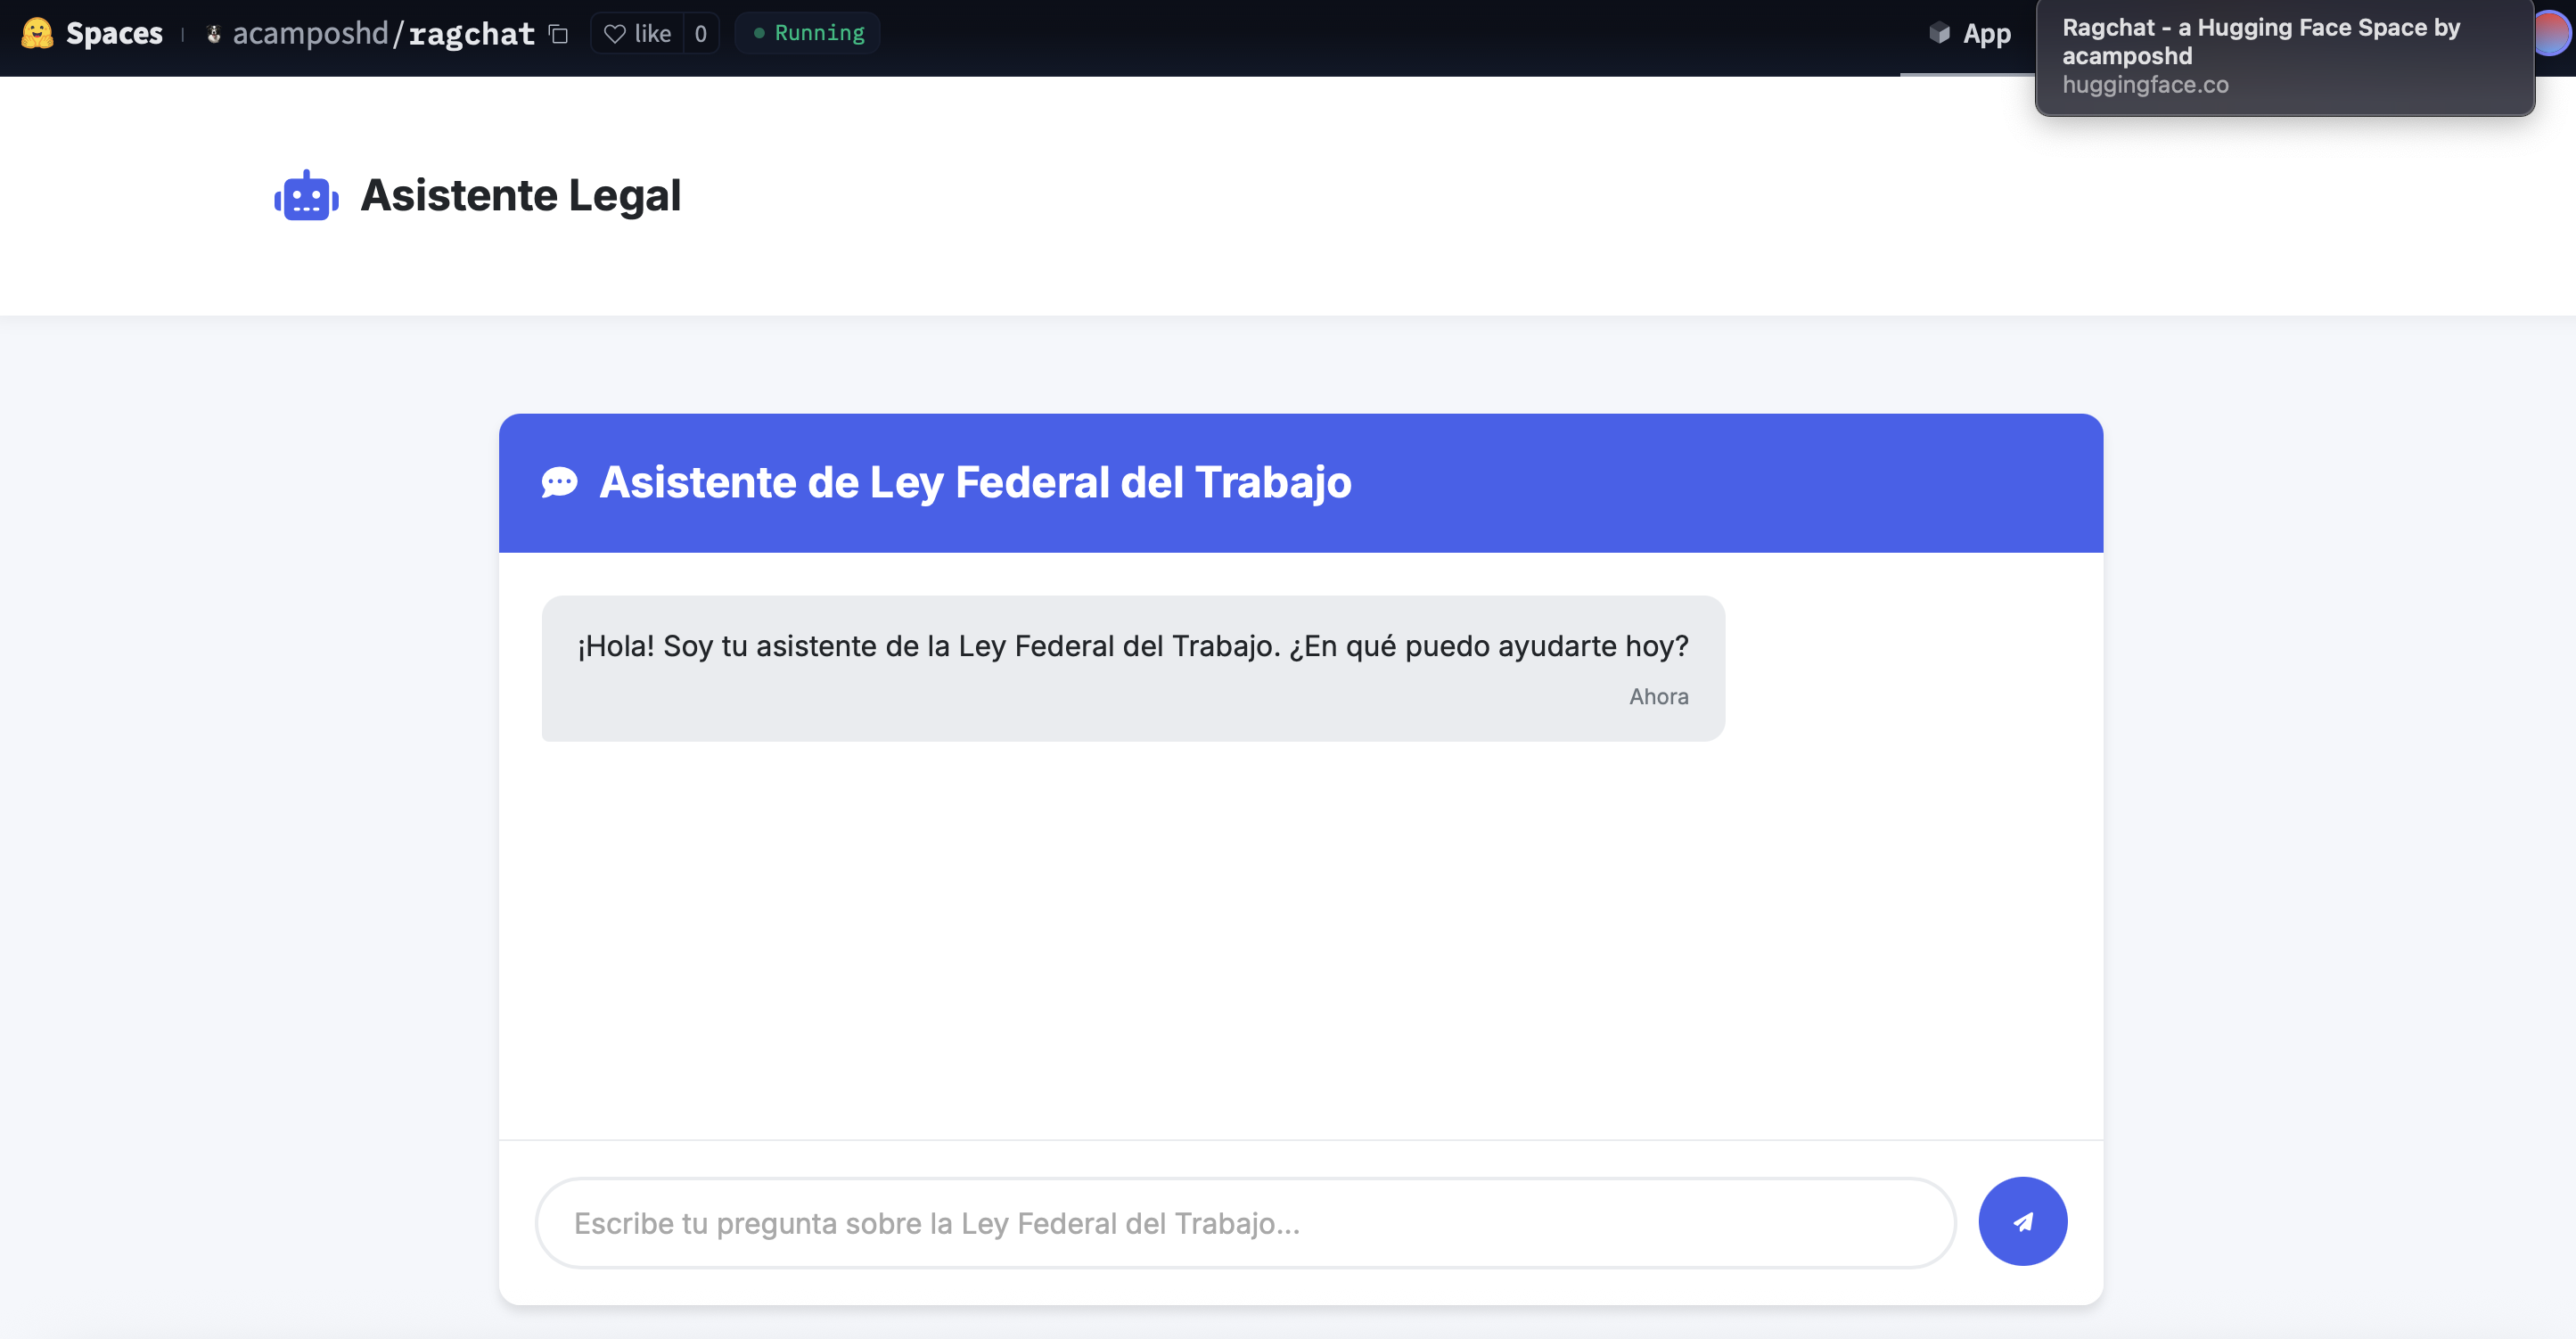
